# 📦 Step 1: Install required packages

In [1]:
!pip install xgboost scikit-learn matplotlib seaborn pandas

# 📊 Step 2: Simulated Benchmark Function

In [2]:
import random
import time

def simulate_sort_run(size, entropy):
    base_time = size * (1 + entropy) / 1e6
    time.sleep(min(base_time, 0.5))  # simulate execution
    avg_power = 75 + (entropy * 25)  # simulated power in Watts
    energy = avg_power * base_time   # Joules = Watts * seconds
    return base_time, energy

# 📁 Step 3: Generate Dataset

In [3]:
import pandas as pd

def generate_dataset():
    rows = []
    for size in [1024, 4096, 16384, 65536, 131072]:
        for entropy in [0.0, 0.5, 1.0]:  # ordered, semi-random, random
            for sort_type in ['radix', 'bitonic', 'merge']:
                temp = random.uniform(50, 75)  # fake temp
                bandwidth = random.choice([320, 512, 640])  # GB/s
                exec_time, energy = simulate_sort_run(size, entropy)
                rows.append({
                    'size': size,
                    'entropy': entropy,
                    'type': sort_type,
                    'bandwidth': bandwidth,
                    'temp': temp,
                    'joules': energy,
                    'time': exec_time
                })
    return pd.DataFrame(rows)

df = generate_dataset()
df.head()

,size,entropy,type,bandwidth,temp,joules,time
0,1024,0.0,radix,512,50.209467,0.0768,0.001024
1,1024,0.0,bitonic,640,63.888925,0.0768,0.001024
2,1024,0.0,merge,512,56.925393,0.0768,0.001024
3,1024,0.5,radix,320,55.940907,0.1344,0.001536
4,1024,0.5,bitonic,512,58.894494,0.1344,0.001536


# 🧠 Step 4: Train ML Model

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

df_encoded = pd.get_dummies(df, columns=['type'])

X = df_encoded.drop(columns=['joules', 'time'])
y = df_encoded['joules']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print(f"MAE on test set: {mae:.2f} Joules")

MAE on test set: 1.16 Joules


# 🔍 Step 5: Backend Predictor

In [5]:
def predict_backend(size, entropy, sort_type, bandwidth, temp, time_diff=0.05):
    input_dict = {
        'size': size,
        'entropy': entropy,
        'bandwidth': bandwidth,
        'temp': temp,
        'type_bitonic': 0,
        'type_merge': 0,
        'type_radix': 0
    }
    input_dict[f'type_{sort_type}'] = 1
    input_df = pd.DataFrame([input_dict])
    predicted_energy = model.predict(input_df)[0]

    if predicted_energy < 350 and time_diff < 0.1:
        return "OpenACC (energy-saving)"
    else:
        return "CUDA (faster)"

# 🔄 Example prediction
backend = predict_backend(16384, 0.5, 'bitonic', 512, 65)
print("Recommended backend:", backend)

Recommended backend: OpenACC (energy-saving)


# 📈 Step 6: Visualization

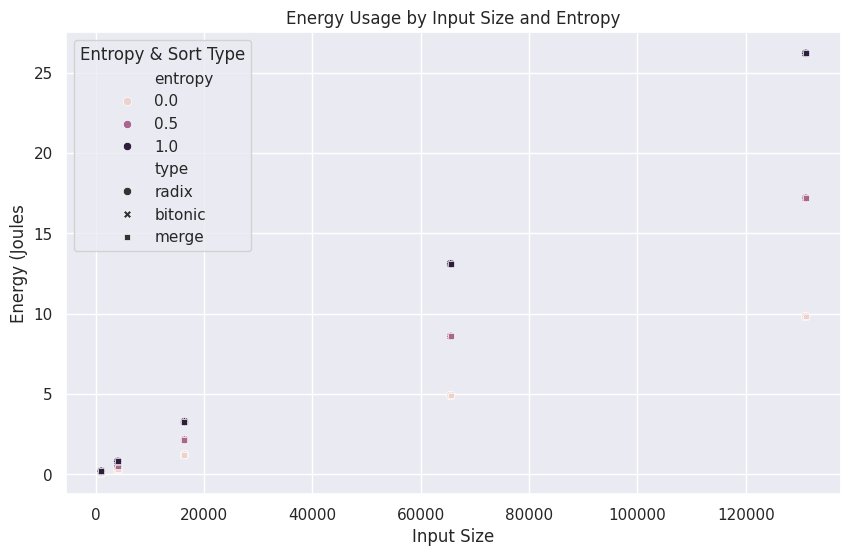

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='size', y='joules', hue='entropy', style='type')
plt.title("Energy Usage by Input Size and Entropy")
plt.xlabel("Input Size")
plt.ylabel("Energy (Joules")
plt.legend(title="Entropy & Sort Type")
plt.show()